In [1]:
#sudo kill -9 $(sudo lsof -t -i:5000)
import torch
from train import Trainer
from dataset import DataPreparation
from models import *
from eval import evaluate_model
from sklearn.metrics import f1_score
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

import mlflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [2]:
class Config:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Thiết bị sử dụng (cuda hoặc cpu)
        self.train_dir = "/home/tari/Documents/BackUp_AI_Class/day04/exercise/dataset/train/"  # Đường dẫn đến dữ liệu huấn luyện
        self.test_dir = '/home/tari/Documents/BackUp_AI_Class/day04/exercise/dataset/test/'
        self.num_classes = None
        self.class_names = None
        self.batch_size = 16
        self.max_epochs = 10
        self.patience = 3
        self.lr = 0.001
        self.beta1 = 0.95
        self.beta2 = 0.993
        self.model_name = 'mobilenetv3'
        self.name_exp = 'classification'
        self.mlflow = mlflow

In [3]:
# Loss
criterion = nn.CrossEntropyLoss()
# Config
cfg = Config()
data_preparation = DataPreparation(
    cfg = cfg
    )

cfg.mlflow.start_run(run_name=f"{cfg.name_exp}")

Số lượng lớp: 6
Tên lớp: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Ánh xạ từ tên lớp sang chỉ số: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Number of train:  14034
Number of test:  3000


<ActiveRun: >

epochs:  10%|█         | 1/10 [00:46<07:00, 46.71s/it]

Epoch 1/10 - Train Loss: 0.3820 - Test Loss: 0.2767 - Train F1: 0.8671 - Test F1: 0.9060


epochs:  20%|██        | 2/10 [01:30<05:59, 44.97s/it]

Epoch 2/10 - Train Loss: 0.2638 - Test Loss: 0.2399 - Train F1: 0.9074 - Test F1: 0.9263


epochs:  30%|███       | 3/10 [02:14<05:11, 44.57s/it]

Epoch 3/10 - Train Loss: 0.2190 - Test Loss: 0.2444 - Train F1: 0.9224 - Test F1: 0.9247


epochs:  40%|████      | 4/10 [02:58<04:26, 44.35s/it]

Epoch 4/10 - Train Loss: 0.1844 - Test Loss: 0.2348 - Train F1: 0.9355 - Test F1: 0.9217


epochs:  50%|█████     | 5/10 [03:42<03:40, 44.16s/it]

Epoch 5/10 - Train Loss: 0.1508 - Test Loss: 0.2711 - Train F1: 0.9471 - Test F1: 0.9217


epochs:  60%|██████    | 6/10 [04:27<02:57, 44.41s/it]

Epoch 6/10 - Train Loss: 0.1318 - Test Loss: 0.2518 - Train F1: 0.9538 - Test F1: 0.9263


epochs:  60%|██████    | 6/10 [05:13<03:29, 52.26s/it]


Epoch 7/10 - Train Loss: 0.1113 - Test Loss: 0.3125 - Train F1: 0.9616 - Test F1: 0.9180
Early stopping triggered.
Training finished.


eval: 100%|██████████| 188/188 [00:07<00:00, 25.93it/s]


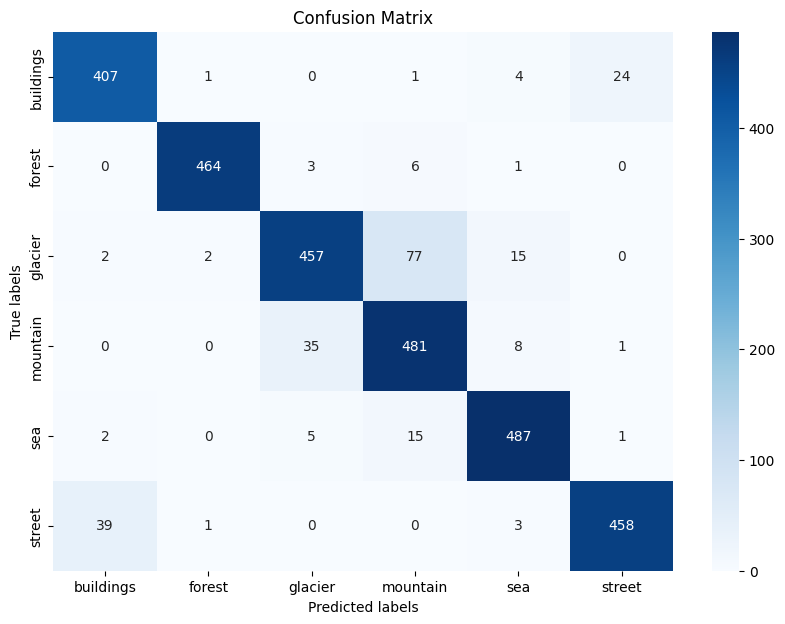

In [4]:

mlflow.log_param("batch_size", cfg.batch_size)
mlflow.log_param("learning_rate", cfg.lr)
mlflow.log_param("beta1", cfg.beta1)
mlflow.log_param("beta2", cfg.beta2)
mlflow.log_param("type_model", cfg.model_name) 


# Create dataloader
data_preparation.create_data_loaders()
trainloader = data_preparation.trainloader
testloader = data_preparation.testloader
cfg.num_classes = data_preparation.num_classes
cfg.class_names = data_preparation.classes_name

# Create Model
if cfg.model_name == 'resnet':
    model = resnet18_frozen(cfg.num_classes)
elif cfg.model_name == 'mobilenetv3':
    model = mobilenetv3_frozen(cfg.num_classes)
elif cfg.model_name == 'efficientnet':
    model = efficientnet_frozen(cfg.num_classes)


# Create Trainer
trainer = Trainer(
    model = model, 
    train_loader=trainloader, 
    test_loader=testloader,
    cfg=cfg
)

optimizer = optim.Adam(model.parameters(), lr=cfg.lr, betas=(cfg.beta1, cfg.beta2))

# Training
trainer.train(
    optimizer=optimizer, 
    scheduler=None,
    criterion=criterion
)
best_model = trainer.model_best_loss
all_predictions, all_true_labels = evaluate_model(
    model=best_model, 
    test_dataloader = testloader, 
    device = cfg.device, 
    class_names = data_preparation.classes_name
)

f1 = f1_score(all_true_labels, all_predictions, average='weighted')
mlflow.log_metric("f1_score", f1)
mlflow.pytorch.log_model(best_model, artifact_path="pytorch-model")